In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function, division, absolute_import
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pyplot as plt
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import time
import pandas as pd
import warnings
import scipy.interpolate as interpolate
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# custom imports
import spike_heatmap

In [3]:
base_path = "/home/atabak/26May/Analysis/Kilosort"
template_marking = np.load(os.path.join(base_path, 'template_marking.npy'))
spike_times = np.load(os.path.join(base_path, 'spike_times.npy'))
spike_templates = np.load(os.path.join(base_path, 'spike_templates.npy'))
types = {0: 'Noise', 1: 'SS', 2: 'SS_Contaminated', 3: 'SS_Putative', 4: 'MUA', 5: 'Unspesified_1',
             6: 'Unspecified_2',
             7: 'Unspecified_3'}

In [4]:
avg_spike_template = np.load(os.path.join(base_path, 'avg_spike_template.npy'))
# avg_spike_template

In [ ]:
avg_spike_template.shape


# plt.plot(avg_spike_template[55,...].T)

In [5]:
prb_path = "/home/atabak/themeaningofbrain/Layouts/Probes/Neuroseeker/prb.txt"

connected = np.squeeze(np.load(os.path.join(base_path, 'channel_map.npy')))
number_of_channels_in_binary_file = 1440
connected_binary = np.in1d(np.arange(number_of_channels_in_binary_file), connected)

bad_channels = np.squeeze(np.argwhere(connected_binary == False).astype(np.int))
  
# view, (x_size, y_size) = create_heatmap_image(avg_spike_template[55,...], prb_path, bad_channels=bad_channels, num_of_shanks=1)

In [14]:
def get_loc(template, plot=False):
  _, _, _, _, p2p = spike_heatmap.peaktopeak(template, window_size=60)
  zlimits = [p2p.min(), p2p.max()]
  probe = spike_heatmap.get_probe_geometry_from_prb_file(prb_path)
  num_of_shanks = 1
  channel_positions = pd.Series(probe[0]['geometry'])
  channel_positions = channel_positions.drop(bad_channels)
  channel_positions.index = np.arange(len(channel_positions))
  total_electrodes = len(channel_positions)
  electrodes_per_shank = int(total_electrodes / num_of_shanks)
  begin_electrode = 0
  end_electrode = electrodes_per_shank
  channel_positions_shank = channel_positions[begin_electrode:end_electrode]
  data = p2p[channel_positions_shank.index]

  hpos = 0
  vpos = 0
  width = None
  height = None
  gridscale = 1
  interpolation_method = "bicubic"

  if np.isnan(data).any():
    warnings.warn('The data passed to contain NaN values. \
    These will create unexpected results in the interpolation. \
    Deal with them.')
  channel_positions = channel_positions.sort_index(ascending=[1])
  channel_positions = np.array([[x, y] for x, y in channel_positions.values])

  if not width and not height:
    x_scaling = 1
    y_scaling = 1

  chan_x = channel_positions[:, 0] * x_scaling + hpos
  chan_y = channel_positions[:, 1] * y_scaling + vpos
  chan_x = np.max(chan_x) - chan_x

  hlim = [np.min(chan_y), np.max(chan_y)]
  vlim = [np.min(chan_x), np.max(chan_x)]

  yi, xi = np.mgrid[hlim[0]:hlim[1]:complex(0, gridscale)*(hlim[1]-hlim[0]),
                    vlim[0]:vlim[1]:complex(0, gridscale)*(vlim[1]-vlim[0])]

  zi = interpolate.griddata((chan_x, chan_y), data, (xi, yi))
  

  if zlimits is None:
      vmin = data.min()
      vmax = data.max()
  else:
      vmin = zlimits[0]
      vmax = zlimits[1]
  if plot:
    cmap = plt.get_cmap("jet")#Uncomment for showing plots
    plt.figure(figsize=(20,70))#Uncomment for showing plots
    image = plt.imshow(zi.T, cmap=cmap, origin=['lower'], vmin=vmin, 
                        vmax=vmax, interpolation=interpolation_method,
                        extent=[hlim[0], hlim[1], vlim[0], vlim[1]],
                        aspect='equal').make_image(renderer=None)
    plt.show() #Uncomment for showing plots
  return plt.gcf(), zi[:-1,:]

In [8]:
print("spike_template shape is {0}".format(spike_templates.shape))
print("spike_template max is {0}".format(spike_templates.max()))
print("template_marking shape is {0}".format(template_marking.shape))
print("spike_template itself is:")
template_marking.shape

spike_template shape is (5915510, 1)
spike_template max is 2397
template_marking shape is (2400,)
spike_template itself is:


(2400,)

In [9]:
start_t = time.time()
spike_times_used = list()
spike_templates_used = list()
for idx, cell in enumerate(spike_templates):
  if template_marking[cell]==1:
    spike_times_used.append(spike_times[idx])
    spike_templates_used.append(cell)
print(time.time()-start_t)

14.4499969482


In [10]:
spike_times_used = np.array(spike_times_used)
spike_templates_used = np.array(spike_templates_used)
print(spike_times_used.shape)

(5015575, 1)
(5015575, 1)


In [ ]:
np.diff(spike_times_used.squeeze()).mean()

In [11]:
unique = np.unique(spike_templates_used)
unique.shape

(1270,)

In [15]:
cell_pos = dict()
location_array = np.arange(tmp.shape[0])
for i, template in enumerate(unique[:50], plot=True):
  mplot, heat = get_loc(avg_spike_template[template,...])
  tmp = np.sum(heat, axis=1)
  tmp_max = tmp.max()
  tmp[tmp<0.8*tmp_max]=0
  cell_pos[template] = np.dot(tmp/tmp.sum(),
                              location_array)
  tmp[3300:]=0
  if (tmp.max()> tmp.mean()+3*tmp.std()) and (tmp.sum() > 0):
    cell_pos[template] = np.dot(tmp/tmp.sum(),
                                location_array)
  print(cell_pos[template])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
cell_pos = dict()

for i, template in enumerate(unique):
  mplot, heat = get_loc(avg_spike_template[template,...])
  tmp = np.sum(heat, axis=1)
  tmp_max = tmp.max()
  tmp[tmp<0.8*tmp_max]=0
  cell_pos[template] = np.dot(tmp/tmp.sum(),
                              location_array)
  tmp[3300:]=0
  if (tmp.max()> tmp.mean()+3*tmp.std()) and (tmp.sum() > 0):
    cell_pos[template] = np.dot(tmp/tmp.sum(),
                                location_array)
  if i%100==0:
    print(i)

neuron2vec
=============

with little modification from udacity tutorial
------------

The goal of this notebook is to train a Neuron2Vec skip-gram model over spiking data of chronic neuroseeker experiment.

In [16]:
spike_times_used.shape

(5015575, 1)

Build the dictionary and replace rare templates with 5000 token.

In [17]:
vocabulary_size = 1200

def build_dataset(words):
  count = [[5000, -1]]
#   count = list()
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:     #r
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']#r
      unk_count = unk_count + 1#r
    data.append(index)
  count[0][1] = unk_count#r
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(spike_templates_used.astype(np.uint16).squeeze().tolist())
# data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words + UNK', count[:5])
print('Sample data', data[:10])
# del words  # Hint to reduce memory.

Most common words + UNK [[5000, 121], (284, 66232), (145, 54738), (430, 44257), (513, 43397)]
Sample data [2, 296, 142, 79, 201, 24, 65, 4, 52, 109]


Function to generate a training batch for the skip-gram model.

In [18]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: [145, 60, 180, 438, 1845, 1570, 1451, 513]

with num_skips = 2 and skip_window = 1:
    batch: [60, 60, 180, 180, 438, 438, 1845, 1845]
    labels: [180, 145, 438, 60, 180, 1845, 438, 1570]

with num_skips = 4 and skip_window = 2:
    batch: [180, 180, 180, 180, 438, 438, 438, 438]
    labels: [438, 60, 145, 1845, 1845, 180, 1570, 60]


Train a skip-gram model.

In [38]:
batch_size = 256
embedding_size = 20 # Dimension of the embedding vector.
skip_window = 50 #3 # How many words to consider left and right.
num_skips = 64 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
# valid_size = 16 # Random set of words to evaluate similarity on.
# valid_window = 100 # Only pick dev samples in the head of the distribution.
# valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 128 # Number of negative examples to sample.

graph = tf.Graph()


with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
#   valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
#   loss = tf.reduce_mean(
#     tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
#                                labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  nce_weights = tf.Variable(
      tf.truncated_normal([vocabulary_size, embedding_size],
                          stddev=1.0 / math.sqrt(embedding_size)))
  nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
# Explanation of the meaning of NCE loss:
#   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
#   optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
#   valid_embeddings = tf.nn.embedding_lookup(
#     normalized_embeddings, valid_dataset)
#   similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [39]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
#     if step % 10000 == 0:
#       sim = similarity.eval()
#       for i in range(valid_size):
#         valid_word = reverse_dictionary[valid_examples[i]]
#         top_k = 8 # number of nearest neighbors
#         nearest = (-sim[i, :]).argsort()[1:top_k+1]
#         log = 'Nearest to %s:' % valid_word
#         for k in range(top_k):
#           close_word = reverse_dictionary[nearest[k]]
#           log = '%s %s,' % (log, close_word)
#         print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 268.487488
Average loss at step 2000: 177.892309
Average loss at step 4000: 49.276291
Average loss at step 6000: 14.899880
Average loss at step 8000: 9.387111
Average loss at step 10000: 8.059717
Average loss at step 12000: 7.005796
Average loss at step 14000: 6.655071
Average loss at step 16000: 6.457884
Average loss at step 18000: 6.336780
Average loss at step 20000: 6.357255
Average loss at step 22000: 6.225942
Average loss at step 24000: 5.977636
Average loss at step 26000: 5.951124
Average loss at step 28000: 5.953342
Average loss at step 30000: 5.757265
Average loss at step 32000: 5.821814
Average loss at step 34000: 5.737874
Average loss at step 36000: 5.790078
Average loss at step 38000: 5.725514
Average loss at step 40000: 5.790605
Average loss at step 42000: 5.685688
Average loss at step 44000: 5.632167
Average loss at step 46000: 5.665570
Average loss at step 48000: 5.672384
Average loss at step 50000: 5.624317
Average loss at step 52000: 

In [33]:
num_points = 200

tsne = TSNE(perplexity=30, n_components=2, 
            init='pca', n_iter=6000, method='exact',
            verbose=2)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.171857
[t-SNE] Iteration 50: error = 62.0402718, gradient norm = 0.5126303 (50 iterations in 0.198s)
[t-SNE] Iteration 100: error = 61.4808198, gradient norm = 0.5395854 (50 iterations in 0.148s)
[t-SNE] Iteration 150: error = 62.3799572, gradient norm = 0.5507739 (50 iterations in 0.133s)
[t-SNE] Iteration 200: error = 61.6351874, gradient norm = 0.5452381 (50 iterations in 0.128s)
[t-SNE] Iteration 250: error = 64.1595869, gradient norm = 0.4530050 (50 iterations in 0.134s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.159587
[t-SNE] Iteration 300: error = 0.9726620, gradient norm = 0.0079272 (50 iterations in 0.157s)
[t-SNE] Iteration 350: error = 0.7870058, gradient norm = 0.0033246 (50 iterations in 0.127s)
[t-SNE] Iteration 400: error = 0.7066569, gradient norm = 0.0023638 (50 iterations in 0.140s)
[t-SNE] Iteration 450: error = 0.

In [34]:

cmap = cm.rainbow
norm = Normalize(vmin=np.min(cell_pos.values()),
                 vmax=np.max(cell_pos.values()))


In [23]:
count_dic = {k:v for k,v in count}

In [ ]:
count_dic[5000]

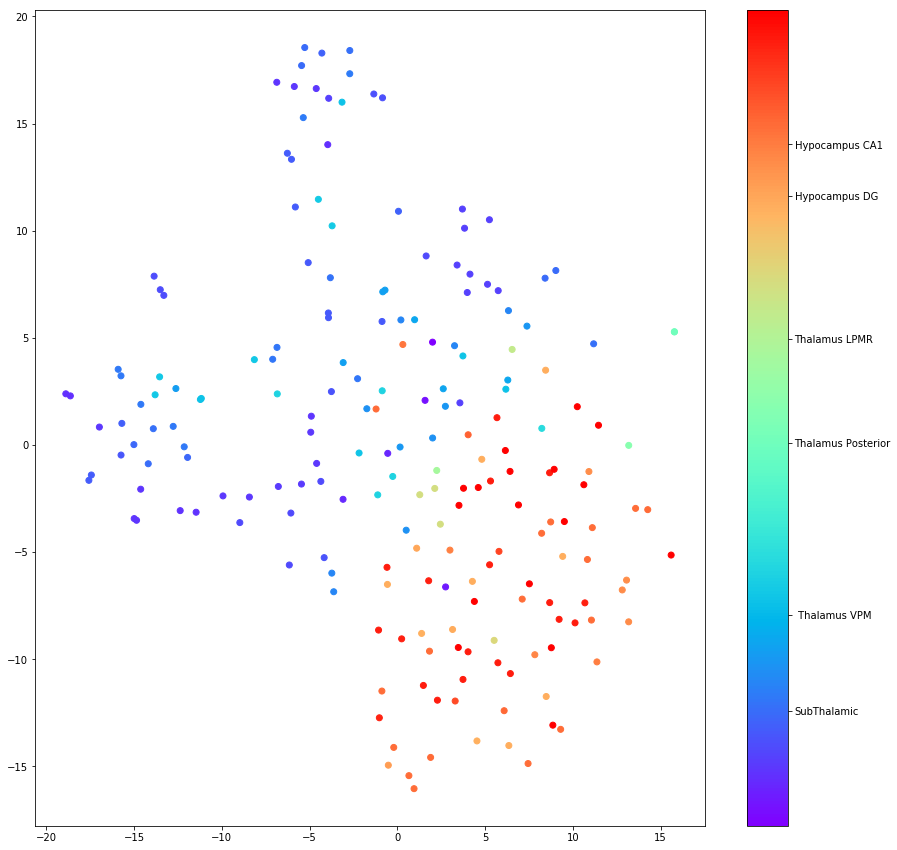

In [37]:

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(15,15))  # in inches
  mcolors = list()
  mcount = list()
  for label in labels:
    mcolors.append(norm(cell_pos[label]))
    mcount.append(str(count_dic[label]))
    
#   for i, label in enumerate(labels):
#   x, y = embeddings[i,:]
  plt.scatter(embeddings[:,0], embeddings[:,1], c=mcolors, cmap=cmap)
#     pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')
#   xyt = np.multiply(np.ones_like(embeddings), np.array((5, 2)))
#   plt.annotate(mcount, xy=(embeddings[:,0], embeddings[:,1]), textcoords='offset points',
#                    ha='right', va='bottom')
#   cb = plt.colorbar( ticks=[0, 0.999])
  cb = plt.colorbar( ticks=[1050/8100, 1930/8100, 3500/8100, 4450/8100, 5760/8100, 6230/8100, 8000/8100])
#   cb.set_label('colorbar label')
#   cb.ax.set_yticklabels(['sub-thalamus', ' top cortex'])
  cb.ax.set_yticklabels(['SubThalamic', ' Thalamus VPM', 'Thalamus Posterior', 
                         'Thalamus LPMR', 'Hypocampus DG', 'Hypocampus CA1', 'Parietal Cortex'])
#   for i, label in enumerate(labels):
#     x, y = embeddings[i,:]
#     plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')
  return plt.gcf()


words = [reverse_dictionary[i] for i in range(1, num_points+1)]
tsne_fig = plot(two_d_embeddings, words)

In [30]:
tsne_fig.savefig('tsne_20.jpg', format='jpg')

In [ ]:
np.array(words)[range(10)]

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---